In [6]:
# Importing Libraries

In [7]:
import pandas as pd
import numpy as np

In [8]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [9]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [10]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [11]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [12]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [13]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [14]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [15]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [16]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [17]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [18]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [19]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [20]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [21]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 15s 2ms/step - loss: 1.3008 - accuracy: 0.4645 - val_loss: 1.0891 - val_accuracy: 0.5565
Epoch 2/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.9056 - accuracy: 0.6171 - val_loss: 0.8277 - val_accuracy: 0.5942
Epoch 3/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.7434 - accuracy: 0.6549 - val_loss: 0.7569 - val_accuracy: 0.6230
Epoch 4/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.6725 - accuracy: 0.6800 - val_loss: 0.6941 - val_accuracy: 0.6651
Epoch 5/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.6236 - accuracy: 0.7116 - val_loss: 0.6568 - val_accuracy: 0.7326
Epoch 6/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.5866 - accuracy: 0.7333 - val_loss: 0.7696 - val_accu

In [20]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  2      381       105        1                   1   
STANDING                 0       86       446        0                   0   
WALKING                  0        0         0      454                  15   
WALKING_DOWNSTAIRS       0        0         0        0                 419   
WALKING_UPSTAIRS         0        7         0        4                  31   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                           27  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 429  


In [21]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 328us/step


In [22]:
score

[0.41655886096877154, 0.8954869508743286]

- With a simple 2 layer architecture we got approx. 89.54% accuracy and a loss of 0.4165
- We can further imporve the performace with Hyperparameter tuning

<h1>1. Assignment</h1>

<h2>1.1 Update LSTM Layer</h2>

In [23]:
# update LSTM layers
n_hidden = 64

- Defining the Architecture of LSTM

In [24]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [26]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.2560 - accuracy: 0.4470 - val_loss: 1.1326 - val_accuracy: 0.4825
Epoch 2/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.9495 - accuracy: 0.6081 - val_loss: 0.8467 - val_accuracy: 0.6912
Epoch 3/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.8132 - accuracy: 0.6473 - val_loss: 0.8576 - val_accuracy: 0.6322
Epoch 4/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.7342 - accuracy: 0.6933 - val_loss: 0.7157 - val_accuracy: 0.7458
Epoch 5/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.5382 - accuracy: 0.7784 - val_loss: 0.5688 - val_accuracy: 0.7984
Epoch 6/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.3811 - accuracy: 0.8579 - val_loss: 0.5755 - val_accuracy: 0.8480
Epoch 7/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.332

In [27]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 509        0        27        0                   0   
SITTING                  0      365       126        0                   0   
STANDING                 0       47       485        0                   0   
WALKING                  0        0         0      459                  25   
WALKING_DOWNSTAIRS       0        0         0        0                 415   
WALKING_UPSTAIRS         0        0         0        4                   4   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            0  
STANDING                           0  
WALKING                           12  
WALKING_DOWNSTAIRS                 5  
WALKING_UPSTAIRS                 463  


In [28]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 411us/step


In [30]:
score

[0.35375094639873494, 0.9148286581039429]

- Updating LSTM layer from 32 to 64 increase the performance from 89.54% to 91.48% and reduce loss from 0.4165 to 0.3537

<h2>1.2 Update Dropout Rate</h2>

<h3>1.2.1 Use 64 LSTM Layer and Dropout rate 0.7</h3>

In [31]:
# update LSTM layers
n_hidden = 64

- Defining the Architecture of LSTM

In [32]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [34]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 21s 3ms/step - loss: 1.2668 - accuracy: 0.4523 - val_loss: 1.0892 - val_accuracy: 0.5199
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.9252 - accuracy: 0.5966 - val_loss: 0.8212 - val_accuracy: 0.6244
Epoch 3/30
7352/7352 [==============================] - 18s 2ms/step - loss: 0.7997 - accuracy: 0.6314 - val_loss: 0.8336 - val_accuracy: 0.6179
Epoch 4/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.7036 - accuracy: 0.6722 - val_loss: 0.7824 - val_accuracy: 0.6216
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6839 - accuracy: 0.7152 - val_loss: 0.6875 - val_accuracy: 0.7248
Epoch 6/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.5654 - accuracy: 0.8130 - val_loss: 0.5180 - val_accuracy: 0.8273
Epoch 7/30
7352/7352 [==============================] - 16s 2ms/step - loss: 0.412

In [35]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [36]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 286us/step


In [37]:
score

[nan, 0.16830675303936005]

- With dropout 0.7 performance reduced drastically

<h3>1.2.2 Use 32 LSTM Layer and Dropout rate 0.7</h3>

In [38]:
# update LSTM layers
n_hidden = 32

- Defining the Architecture of LSTM

In [39]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 15s 2ms/step - loss: 1.4131 - accuracy: 0.4053 - val_loss: 1.2057 - val_accuracy: 0.5199
Epoch 2/30
7352/7352 [==============================] - 16s 2ms/step - loss: 1.1514 - accuracy: 0.5004 - val_loss: 1.0854 - val_accuracy: 0.5212
Epoch 3/30
7352/7352 [==============================] - 14s 2ms/step - loss: 1.0306 - accuracy: 0.5483 - val_loss: 0.9328 - val_accuracy: 0.6186
Epoch 4/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.8413 - accuracy: 0.6328 - val_loss: 0.8098 - val_accuracy: 0.6403
Epoch 5/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.7508 - accuracy: 0.6718 - val_loss: 0.7237 - val_accuracy: 0.6481
Epoch 6/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.7021 - accuracy: 0.7036 - val_loss: 0.7130 - val_accuracy: 0.6977
Epoch 7/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.625

In [42]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      280       206        1                   1   
STANDING                 0       34       489        4                   2   
WALKING                  0        0         0      360                  33   
WALKING_DOWNSTAIRS       0        0         0        3                 416   
WALKING_UPSTAIRS         1        3         0       28                  24   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            3  
STANDING                           3  
WALKING                          103  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 415  


In [43]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 243us/step


In [44]:
score

[0.596762544016313, 0.8381404876708984]

- Better than 64 layer with same dropout 0.7

<h3>1.2.3 Use 64 LSTM Layer and Dropout rate 0.6</h3>

In [45]:
# update LSTM layers
n_hidden = 64

- Defining the Architecture of LSTM

In [46]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [48]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 19s 3ms/step - loss: 1.2606 - accuracy: 0.4646 - val_loss: 1.0564 - val_accuracy: 0.5443
Epoch 2/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.8792 - accuracy: 0.6002 - val_loss: 0.8393 - val_accuracy: 0.6179
Epoch 3/30
7352/7352 [==============================] - 18s 2ms/step - loss: 0.7371 - accuracy: 0.6447 - val_loss: 0.7495 - val_accuracy: 0.6183
Epoch 4/30
7352/7352 [==============================] - 18s 2ms/step - loss: 0.6515 - accuracy: 0.7088 - val_loss: 0.6700 - val_accuracy: 0.7048
Epoch 5/30
7352/7352 [==============================] - 18s 2ms/step - loss: 0.4806 - accuracy: 0.8392 - val_loss: 0.5685 - val_accuracy: 0.8073
Epoch 6/30
7352/7352 [==============================] - 18s 2ms/step - loss: 0.2974 - accuracy: 0.9057 - val_loss: 0.4664 - val_accuracy: 0.8660
Epoch 7/30
7352/7352 [==============================] - 18s 2ms/step - loss: 0.247

In [49]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 517        0        19        0                   0   
SITTING                  0      416        74        0                   0   
STANDING                 0       94       438        0                   0   
WALKING                  0        0         0      495                   0   
WALKING_DOWNSTAIRS       0        0         0       15                 377   
WALKING_UPSTAIRS         0        0         0       41                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           0  
WALKING                            1  
WALKING_DOWNSTAIRS                28  
WALKING_UPSTAIRS                 427  


In [50]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 283us/step


In [51]:
score

[0.4956902541945778, 0.9060060977935791]

- Better than 0.7 dropout

<h3>1.2.4 Use 32 LSTM Layer and Dropout rate 0.6</h3>

In [52]:
# update LSTM layers
n_hidden = 32

- Defining the Architecture of LSTM

In [53]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [55]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 17s 2ms/step - loss: 1.3738 - accuracy: 0.3864 - val_loss: 1.3047 - val_accuracy: 0.4381
Epoch 2/30
7352/7352 [==============================] - 15s 2ms/step - loss: 1.0837 - accuracy: 0.5292 - val_loss: 1.0199 - val_accuracy: 0.5565
Epoch 3/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.8871 - accuracy: 0.6268 - val_loss: 0.8298 - val_accuracy: 0.6121
Epoch 4/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.7479 - accuracy: 0.6549 - val_loss: 0.7888 - val_accuracy: 0.6149
Epoch 5/30
7352/7352 [==============================] - 16s 2ms/step - loss: 0.7072 - accuracy: 0.6639 - val_loss: 0.8324 - val_accuracy: 0.6020
Epoch 6/30
7352/7352 [==============================] - 15s 2ms/step - loss: 0.6625 - accuracy: 0.6814 - val_loss: 0.8694 - val_accuracy: 0.5979
Epoch 7/30
7352/7352 [==============================] - 14s 2ms/step - loss: 0.641

In [56]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        24        0                   0   
SITTING                  3      434        29        7                   0   
STANDING                 0      135       379        1                   0   
WALKING                  0        1         0      409                  20   
WALKING_DOWNSTAIRS       0        0         0        7                 399   
WALKING_UPSTAIRS         0        0         0        5                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             3  
SITTING                           18  
STANDING                          17  
WALKING                           66  
WALKING_DOWNSTAIRS                14  
WALKING_UPSTAIRS                 466  


In [57]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 256us/step


In [58]:
score

[0.5602035771178105, 0.8812351822853088]

- It's perform worse than 64 layer with dropout 0.6

<h2>1.3 Use 2 LSTM Layers with Larger Dropout</h2>

<h3>1.3.1 LSTM Layer (64,32) with 2 layer of dropout 0.7</h3>

In [95]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 32

- Initialize the LSTM Architecture

In [96]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.7))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [98]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 85s 12ms/step - loss: 1.2737 - accuracy: 0.4884 - val_loss: 0.9074 - val_accuracy: 0.5938
Epoch 2/30
7352/7352 [==============================] - 88s 12ms/step - loss: 0.8894 - accuracy: 0.6167 - val_loss: 0.7144 - val_accuracy: 0.6206
Epoch 3/30
7352/7352 [==============================] - 85s 12ms/step - loss: 0.7967 - accuracy: 0.6294 - val_loss: 0.7580 - val_accuracy: 0.6237
Epoch 4/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.7435 - accuracy: 0.6506 - val_loss: 0.7531 - val_accuracy: 0.6216
Epoch 5/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.7146 - accuracy: 0.6518 - val_loss: 0.7442 - val_accuracy: 0.6315
Epoch 6/30
7352/7352 [==============================] - 84s 11ms/step - loss: 0.7182 - accuracy: 0.6578 - val_loss: 0.7171 - val_accuracy: 0.6328
Epoch 7/30
7352/7352 [==============================] - 86s 12ms/step - loss

In [99]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [100]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [101]:
score

[nan, 0.16830675303936005]

- It's performance is worst

<h3>1.3.2 LSTM Layer (64,32) with 2 layer dropout 0.6</h3>

In [102]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 32

- Initialize the LSTM Architecture

In [103]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.6))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [105]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 78s 11ms/step - loss: 1.2568 - accuracy: 0.4778 - val_loss: 1.2977 - val_accuracy: 0.4462
Epoch 2/30
7352/7352 [==============================] - 77s 10ms/step - loss: 0.8864 - accuracy: 0.6138 - val_loss: 0.8237 - val_accuracy: 0.6179
Epoch 3/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.7344 - accuracy: 0.6719 - val_loss: 0.7058 - val_accuracy: 0.6804
Epoch 4/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.6797 - accuracy: 0.7223 - val_loss: 0.6778 - val_accuracy: 0.7411
Epoch 5/30
7352/7352 [==============================] - 78s 11ms/step - loss: 0.5348 - accuracy: 0.8092 - val_loss: 0.4354 - val_accuracy: 0.8537
Epoch 6/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.3872 - accuracy: 0.8938 - val_loss: 0.4438 - val_accuracy: 0.8799
Epoch 7/30
7352/7352 [==============================] - 76s 10ms/step - loss

In [106]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [107]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [108]:
score

[nan, 0.16830675303936005]

- It's performance is worst

<h3>1.3.3 LSTM Layer (64,32) with 2 layer dropout 0.5</h3>

In [110]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 32

In [111]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [112]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [113]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 96s 13ms/step - loss: 1.0873 - accuracy: 0.5563 - val_loss: 0.7762 - val_accuracy: 0.7038
Epoch 2/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6862 - accuracy: 0.7337 - val_loss: 0.5855 - val_accuracy: 0.7299
Epoch 3/30
7352/7352 [==============================] - 118s 16ms/step - loss: 0.5282 - accuracy: 0.7763 - val_loss: 0.5286 - val_accuracy: 0.7615
Epoch 4/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.4156 - accuracy: 0.8392 - val_loss: 0.4071 - val_accuracy: 0.8819
Epoch 5/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.2848 - accuracy: 0.9139 - val_loss: 0.4556 - val_accuracy: 0.8755
Epoch 6/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.2346 - accuracy: 0.9327 - val_loss: 0.5155 - val_accuracy: 0.8731
Epoch 7/30
7352/7352 [==============================] - 83s 11ms/step - los

In [114]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      397        91        0                   0   
STANDING                 0       92       440        0                   0   
WALKING                  0        1         1      458                  28   
WALKING_DOWNSTAIRS       0        0         0        1                 410   
WALKING_UPSTAIRS         1        0         6       16                  10   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                            8  
WALKING_DOWNSTAIRS                 9  
WALKING_UPSTAIRS                 438  


In [115]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [116]:
score

[0.6456601167650766, 0.900237500667572]

- It's performance is better than 0.7 and 0.6 but loss is considerably high

<h3>1.3.4 LSTM Layer (64,32) with 1 layer of dropout 0.7</h3>

In [117]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 32

In [118]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.5))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
lstm_53 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [119]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [120]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 97s 13ms/step - loss: 1.2252 - accuracy: 0.4883 - val_loss: 0.9514 - val_accuracy: 0.5755
Epoch 2/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.8989 - accuracy: 0.6023 - val_loss: 0.7508 - val_accuracy: 0.6498
Epoch 3/30
7352/7352 [==============================] - 81s 11ms/step - loss: 0.7873 - accuracy: 0.6359 - val_loss: 0.7832 - val_accuracy: 0.6159
Epoch 4/30
7352/7352 [==============================] - 76s 10ms/step - loss: 0.7230 - accuracy: 0.6726 - val_loss: 0.8069 - val_accuracy: 0.5959
Epoch 5/30
7352/7352 [==============================] - 78s 11ms/step - loss: 0.6513 - accuracy: 0.6876 - val_loss: 0.7456 - val_accuracy: 0.6227
Epoch 6/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.5906 - accuracy: 0.7155 - val_loss: 0.6538 - val_accuracy: 0.7469
Epoch 7/30
7352/7352 [==============================] - 75s 10ms/step - loss

In [121]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                WALKING
True                       
LAYING                  537
SITTING                 491
STANDING                532
WALKING                 496
WALKING_DOWNSTAIRS      420
WALKING_UPSTAIRS        471


In [122]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 6s 2ms/step


In [123]:
score

[nan, 0.16830675303936005]

- It's performance is worst

<h3>1.3.5 LSTM Layer (64,32) with 1 layer of dropout 0.6</h3>

In [124]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 32

In [125]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.5))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
lstm_55 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [126]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [127]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 118s 16ms/step - loss: 1.2553 - accuracy: 0.4732 - val_loss: 0.9856 - val_accuracy: 0.6434
Epoch 2/30
7352/7352 [==============================] - 108s 15ms/step - loss: 0.9545 - accuracy: 0.6049 - val_loss: 0.8514 - val_accuracy: 0.6244
Epoch 3/30
7352/7352 [==============================] - 136s 18ms/step - loss: 0.7894 - accuracy: 0.6738 - val_loss: 0.6679 - val_accuracy: 0.7408
Epoch 4/30
7352/7352 [==============================] - 119s 16ms/step - loss: 0.6387 - accuracy: 0.7881 - val_loss: 0.5631 - val_accuracy: 0.7842
Epoch 5/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.4644 - accuracy: 0.8754 - val_loss: 0.4742 - val_accuracy: 0.8548
Epoch 6/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.3441 - accuracy: 0.9072 - val_loss: 0.3645 - val_accuracy: 0.8972
Epoch 7/30
7352/7352 [==============================] - 76s 10ms/step - 

In [128]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  2      400        87        0                   0   
STANDING                 0       95       436        1                   0   
WALKING                  0        0         0      450                   3   
WALKING_DOWNSTAIRS       0        0         0        2                 414   
WALKING_UPSTAIRS         1        0         0       11                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           43  
WALKING_DOWNSTAIRS                 4  
WALKING_UPSTAIRS                 456  


In [129]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [130]:
score

[0.5375813010956876, 0.9053274393081665]

- It's performance is better but loss is higher

<h3>1.3.6 LSTM Layer (64,32) with 1 layer of dropout 0.5</h3>

In [131]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 32

In [132]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.5))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
lstm_57 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________________________________________________________


In [133]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [134]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 80s 11ms/step - loss: 1.1323 - accuracy: 0.5397 - val_loss: 0.8477 - val_accuracy: 0.6787
Epoch 2/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.7404 - accuracy: 0.7203 - val_loss: 0.5979 - val_accuracy: 0.7699
Epoch 3/30
7352/7352 [==============================] - 74s 10ms/step - loss: 0.5092 - accuracy: 0.8400 - val_loss: 1.2509 - val_accuracy: 0.6763
Epoch 4/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.3954 - accuracy: 0.8917 - val_loss: 0.4537 - val_accuracy: 0.8300
Epoch 5/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.2696 - accuracy: 0.9217 - val_loss: 0.3626 - val_accuracy: 0.8887
Epoch 6/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.2443 - accuracy: 0.9300 - val_loss: 0.3439 - val_accuracy: 0.8975
Epoch 7/30
7352/7352 [==============================] - 76s 10ms/step - loss

In [135]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        25        0                   0   
SITTING                  3      416        68        0                   2   
STANDING                 0       96       434        1                   0   
WALKING                  0        0         2      473                  20   
WALKING_DOWNSTAIRS       0        0         0        4                 413   
WALKING_UPSTAIRS         0        1         6       16                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             2  
SITTING                            2  
STANDING                           1  
WALKING                            1  
WALKING_DOWNSTAIRS                 3  
WALKING_UPSTAIRS                 448  


In [136]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [137]:
score

[0.3804781971405892, 0.9141499996185303]

- It's perform much better compared to 0.6 and 0.7

<h3>1.3.7 LSTM Layer (64,16) with dropout 0.5</h3>

In [141]:
# update LSTM layers
n_hidden_1 = 64
n_hidden_2 = 16

- Initialize the LSTM Architecture

In [142]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.6))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
lstm_61 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_37 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 102       
Total params: 24,230
Trainable params: 24,230
Non-trainable params: 0
_________________________________________________________________


In [143]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [144]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 87s 12ms/step - loss: 1.2980 - accuracy: 0.5016 - val_loss: 1.0061 - val_accuracy: 0.5796
Epoch 2/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.9582 - accuracy: 0.6060 - val_loss: 0.8328 - val_accuracy: 0.6495
Epoch 3/30
7352/7352 [==============================] - 80s 11ms/step - loss: 0.8071 - accuracy: 0.7008 - val_loss: 0.6999 - val_accuracy: 0.7710
Epoch 4/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.6449 - accuracy: 0.7953 - val_loss: 0.5793 - val_accuracy: 0.8297
Epoch 5/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.5014 - accuracy: 0.8687 - val_loss: 0.5518 - val_accuracy: 0.8422
Epoch 6/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.4958 - accuracy: 0.8734 - val_loss: 0.3736 - val_accuracy: 0.8860
Epoch 7/30
7352/7352 [==============================] - 81s 11ms/step - loss

In [145]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         3        0                   0   
SITTING                  5      425        57        2                   0   
STANDING                 0      101       430        0                   0   
WALKING                  0        0         0      444                  34   
WALKING_DOWNSTAIRS       0        0         0        5                 401   
WALKING_UPSTAIRS         0        0         0        0                  12   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            24  
SITTING                            2  
STANDING                           1  
WALKING                           18  
WALKING_DOWNSTAIRS                14  
WALKING_UPSTAIRS                 459  


In [146]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [147]:
score

[0.5414807511955393, 0.9056667685508728]

- It's performance is good but loss is high

<h3>1.3.8 LSTM Layer (32,16) with dropout 0.5</h3>

In [148]:
# update LSTM layers
n_hidden_1 = 32
n_hidden_2 = 16

- Initialize the LSTM Architecture

In [149]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.6))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
lstm_63 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_38 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [150]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [151]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 108s 15ms/step - loss: 1.3059 - accuracy: 0.4993 - val_loss: 1.0121 - val_accuracy: 0.5724
Epoch 2/30
7352/7352 [==============================] - 113s 15ms/step - loss: 0.9606 - accuracy: 0.5797 - val_loss: 0.7977 - val_accuracy: 0.6081
Epoch 3/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.8199 - accuracy: 0.6274 - val_loss: 0.7922 - val_accuracy: 0.5938
Epoch 4/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.7544 - accuracy: 0.6387 - val_loss: 0.7379 - val_accuracy: 0.6179
Epoch 5/30
7352/7352 [==============================] - 111s 15ms/step - loss: 0.7201 - accuracy: 0.6538 - val_loss: 0.7295 - val_accuracy: 0.6315
Epoch 6/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.7087 - accuracy: 0.6568 - val_loss: 0.7252 - val_accuracy: 0.6247
Epoch 7/30
7352/7352 [==============================] - 92s 13ms/step - l

In [152]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         1        0                   0   
SITTING                  1      414        71        2                   1   
STANDING                 0       80       445        7                   0   
WALKING                  0        0         0      458                   9   
WALKING_DOWNSTAIRS       0        6         0        1                 403   
WALKING_UPSTAIRS         0        1         0        4                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           29  
WALKING_DOWNSTAIRS                10  
WALKING_UPSTAIRS                 463  


In [153]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 1ms/step


In [154]:
score

[0.3589311393391746, 0.922633171081543]

- It's performance is best till now, I got 92.26% accuracy and loss 0.3589

<h3>1.3.9 LSTM Layer (32,8) with dropout 0.5</h3>

In [155]:
# update LSTM layers
n_hidden_1 = 32
n_hidden_2 = 8

- Initialize the LSTM Architecture

In [156]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.6))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
lstm_65 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
dropout_39 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 54        
Total params: 6,742
Trainable params: 6,742
Non-trainable params: 0
_________________________________________________________________


In [157]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [158]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 72s 10ms/step - loss: 1.4856 - accuracy: 0.4123 - val_loss: 1.3371 - val_accuracy: 0.4608
Epoch 2/30
7352/7352 [==============================] - 71s 10ms/step - loss: 1.2285 - accuracy: 0.5116 - val_loss: 1.0945 - val_accuracy: 0.5270
Epoch 3/30
7352/7352 [==============================] - 73s 10ms/step - loss: 1.0665 - accuracy: 0.5305 - val_loss: 0.9436 - val_accuracy: 0.5541
Epoch 4/30
7352/7352 [==============================] - 75s 10ms/step - loss: 0.9660 - accuracy: 0.5257 - val_loss: 0.9440 - val_accuracy: 0.4880
Epoch 5/30
7352/7352 [==============================] - 71s 10ms/step - loss: 0.9060 - accuracy: 0.5547 - val_loss: 0.8240 - val_accuracy: 0.5684
Epoch 6/30
7352/7352 [==============================] - 74s 10ms/step - loss: 0.8786 - accuracy: 0.5654 - val_loss: 0.7971 - val_accuracy: 0.6529
Epoch 7/30
7352/7352 [==============================] - 75s 10ms/step - loss

In [159]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 534        0         0        0                   0   
SITTING                  0      420        61        0                   0   
STANDING                 0      122       405        0                   0   
WALKING                  0        0         0        0                   0   
WALKING_DOWNSTAIRS       0        0         0        4                 397   
WALKING_UPSTAIRS         0        5         0        0                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             3  
SITTING                           10  
STANDING                           5  
WALKING                          496  
WALKING_DOWNSTAIRS                19  
WALKING_UPSTAIRS                 466  


In [160]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 953us/step


In [161]:
score

[0.3761567989555303, 0.7539871335029602]

- Performance degraded for this combination of LSTM

<h3>1.4.0 Assignment feedback to improve accuracy > 94% </h3>

<h3>1.4.1 Increase dropout on the best LSTM combination</h3>

In [17]:
# update LSTM layers
n_hidden_1 = 32
n_hidden_2 = 16

- Initialize the LSTM Architecture

In [18]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.6))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 28s 4ms/step - loss: 1.3771 - accuracy: 0.4679 - val_loss: 1.2075 - val_accuracy: 0.5063
Epoch 2/30
7352/7352 [==============================] - 29s 4ms/step - loss: 1.0661 - accuracy: 0.5615 - val_loss: 0.9215 - val_accuracy: 0.6546
Epoch 3/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.9246 - accuracy: 0.6035 - val_loss: 0.7882 - val_accuracy: 0.6474
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.8082 - accuracy: 0.6484 - val_loss: 0.9662 - val_accuracy: 0.6223
Epoch 5/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.7176 - accuracy: 0.7084 - val_loss: 0.7233 - val_accuracy: 0.6702
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.6610 - accuracy: 0.7329 - val_loss: 0.6340 - val_accu

In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         2        0                   0   
SITTING                  0      404        87        0                   0   
STANDING                 0       81       450        1                   0   
WALKING                  0        0         0      450                  44   
WALKING_DOWNSTAIRS       0        0         0        0                 414   
WALKING_UPSTAIRS         1        0        10        0                   6   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            25  
SITTING                            0  
STANDING                           0  
WALKING                            2  
WALKING_DOWNSTAIRS                 6  
WALKING_UPSTAIRS                 454  


In [22]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 402us/step


In [23]:
score

[0.36157595883878874, 0.9100780487060547]

<h3>1.4.2 Decrease dropout on the best LSTM combination</h3>

In [24]:
# update LSTM layers
n_hidden_1 = 32
n_hidden_2 = 16

- Initialize the LSTM architecture

In [25]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim), return_sequences=True))
# Adding a dropout layer
# model.add(Dropout(0.6))
# Configuring the parameters
model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2955 - accuracy: 0.5092 - val_loss: 0.9788 - val_accuracy: 0.5667
Epoch 2/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.9335 - accuracy: 0.6260 - val_loss: 0.8553 - val_accuracy: 0.5850
Epoch 3/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.7509 - accuracy: 0.6903 - val_loss: 0.6851 - val_accuracy: 0.6875
Epoch 4/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.6576 - accuracy: 0.7371 - val_loss: 0.6529 - val_accuracy: 0.7153
Epoch 5/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.5653 - accuracy: 0.7776 - val_loss: 0.5315 - val_accuracy: 0.7598
Epoch 6/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.4963 - accuracy: 0.7875 - val_loss: 0.5693 - val_accuracy: 0.7397
Epoch 7/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.459

In [28]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  4      387        78        0                   4   
STANDING                 0       98       432        0                   0   
WALKING                  0        0         0      448                  10   
WALKING_DOWNSTAIRS       0        0         0        0                 413   
WALKING_UPSTAIRS         0        0         0        7                   9   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           18  
STANDING                           2  
WALKING                           38  
WALKING_DOWNSTAIRS                 7  
WALKING_UPSTAIRS                 455  


In [29]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 397us/step


In [30]:
score

[0.39125852214684165, 0.9066847562789917]

<h3>1.4.3 Increase layer size to 128 and lesser dropout</h3>

In [37]:
# update LSTM layers
n_hidden_1 = 128
# n_hidden_2 = 16

- Initialize LSTM

In [38]:
# https://stackoverflow.com/questions/51763983/error-when-checking-target-expected-dense-1-to-have-3-dimensions-but-got-array
# https://github.com/keras-team/keras/issues/7403
# 1. You need to set return_sequences=True from first LSTM
# 2. You need to set return_sequences=True from second LSTM
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden_1, input_shape=(timesteps, input_dim)))#, return_sequences=True
# Adding BatchNormalization
model.add(BatchNormalization())
# Adding a dropout layer
# model.add(Dropout(0.6))
# Configuring the parameters
# model.add(LSTM(n_hidden_2 , return_sequences=False))
# Adding a dropout layer
model.add(Dropout(0.25))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               70656     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 71,942
Trainable params: 71,686
Non-trainable params: 256
_________________________________________________________________


In [39]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [40]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.9291 - accuracy: 0.5952 - val_loss: 0.7638 - val_accuracy: 0.6359
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.6998 - accuracy: 0.6602 - val_loss: 0.6965 - val_accuracy: 0.6481
Epoch 3/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.5196 - accuracy: 0.7916 - val_loss: 0.3441 - val_accuracy: 0.8907
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2674 - accuracy: 0.9101 - val_loss: 0.3433 - val_accuracy: 0.8989
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1985 - accuracy: 0.9293 - val_loss: 0.3900 - val_accuracy: 0.8772
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1990 - accuracy: 0.9279 - val_loss: 0.3218 - val_accuracy: 0.9121
Epoch 7/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.179

In [41]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      418        71        0                   0   
STANDING                 0      101       431        0                   0   
WALKING                  0        0         0      470                  24   
WALKING_DOWNSTAIRS       0        0         0        1                 417   
WALKING_UPSTAIRS         0        1         0       13                   2   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                            2  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 455  


In [42]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 542us/step


In [43]:
score

[0.31214076887265046, 0.9256871342658997]

<h3>1.4.4 Implement Divide and Conquer Technique</h3>

In [ ]:
# Citation: https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN

In the dataset, Y_labels are represented as numbers from 1 to 6 as their identifiers.  
WALKING as 1  
WALKING_UPSTAIRS as 2  
WALKING_DOWNSTAIRS as 3  
SITTING as 4  
STANDING as 5  
LAYING as 6    
- in Data exploration section we observed that we can divide the data into dynamic and static type so divided walking, walking_upstairs and walking_downstairs into category 0 i.e Dynamic and sitting, standing and laying into category 1 i.e. static. 
- Will use 2 more classifiers separately for classifying classes of dynamic and static activities. so that model can learn differnt features for static and dynamic activities


referred below paper  
Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening ( https://www.mdpi.com/1424-8220/18/4/1055/pdf )

In [38]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(0)
rn.seed(0)
tf.set_random_seed(0)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(0)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Importing libraries
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
import pickle

In [39]:
## Classifying data as 2 class dynamic vs static 
##data preparation
def data_scaled_2class():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            ##saving for furter usage
            ## will use in predicton pipeline
            pickle.dump(scale,open('Scale_2class.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y[y<=3] = 0
        y[y>3] = 1
        return pd.get_dummies(y).as_matrix()
    
    X_train_2c, X_val_2c = load_signals('train'), load_signals('test')
    Y_train_2c, Y_val_2c = load_y('train'), load_y('test')
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_2c)
    X_train_2c = Scale.transform(X_train_2c)
    X_val_2c = Scale.transform(X_val_2c)
    return X_train_2c, Y_train_2c, X_val_2c,  Y_val_2c

In [40]:
X_train_2c, Y_train_2c, X_val_2c,  Y_val_2c = data_scaled_2class()

/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [41]:
print(Y_train_2c.shape)
print(Y_val_2c.shape)

(7352, 2)
(2947, 2)


<h3> 1.4.4.1 Model for classifying data into Static and Dynamic activities</h3>

In [42]:
K.clear_session()
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_2 (Dense)              (None, 2)               

In [44]:
import keras
import math
adam = keras.optimizers.Adam(lr=0.001)

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_2c,Y_train_2c, epochs=20, batch_size=16,validation_data=(X_val_2c, Y_val_2c), verbose=1)


Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 4s 578us/step - loss: 0.0539 - accuracy: 0.9786 - val_loss: 0.0119 - val_accuracy: 0.9980
Epoch 2/20
7352/7352 [==============================] - 4s 537us/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0181 - val_accuracy: 0.9959
Epoch 3/20
7352/7352 [==============================] - 4s 509us/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0088 - val_accuracy: 0.9983
Epoch 4/20
7352/7352 [==============================] - 4s 554us/step - loss: 5.9931e-05 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9980
Epoch 5/20
7352/7352 [==============================] - 4s 517us/step - loss: 4.5958e-05 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9983
Epoch 6/20
7352/7352 [==============================] - 4s 511us/step - loss: 2.1727e-05 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9980
Epoch 7/20
7352/7352 [==============================] - 4s 555u

In [46]:
_,acc_val = model.evaluate(X_val_2c,Y_val_2c,verbose=0)
_,acc_train = model.evaluate(X_train_2c,Y_train_2c,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.9935527443885803


In [47]:
##saving model
model.save('final_model_2class.h5')

- Classification of Static and Dynamic Activities is Perfect, We got 99.35% accuracy on test data

<h3>1.4.4.2 Model for Classifying Static Activities</h3>

In [48]:
##data preparation
def data_scaled_static():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            #for furter use at prediction pipeline
            pickle.dump(scale,open('Scale_static.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_subset = y>3
        y = y[y_subset]
        return pd.get_dummies(y).as_matrix(),y_subset
    
    Y_train_s,y_train_sub = load_y('train')
    Y_val_s,y_test_sub = load_y('test')
    X_train_s, X_val_s = load_signals('train'), load_signals('test')
    X_train_s = X_train_s[y_train_sub]
    X_val_s = X_val_s[y_test_sub]
    
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_s)
    X_train_s = Scale.transform(X_train_s)
    X_val_s = Scale.transform(X_val_s)

    return X_train_s, Y_train_s, X_val_s,  Y_val_s

In [49]:
X_train_s, Y_train_s, X_val_s,  Y_val_s = data_scaled_static()

/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [50]:
print('X Shape of train data',X_train_s.shape, 'Y shape', Y_train_s.shape)
print('X Shape of val data',X_val_s.shape,'Y shape',Y_val_s.shape)

X Shape of train data (4067, 128, 9) Y shape (4067, 3)
X Shape of val data (1560, 128, 9) Y shape (1560, 3)


- Model to distinguish Static Activities

In [55]:
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 122, 64)           4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                38430     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [56]:
import math
adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=20, batch_size=32,validation_data=(X_val_s, Y_val_s), verbose=1)
# K.clear_session()

Train on 4067 samples, validate on 1560 samples
Epoch 1/20
4067/4067 [==============================] - 2s 512us/step - loss: 0.3530 - accuracy: 0.8832 - val_loss: 0.3818 - val_accuracy: 0.8769
Epoch 2/20
4067/4067 [==============================] - 2s 453us/step - loss: 0.2075 - accuracy: 0.9201 - val_loss: 0.2615 - val_accuracy: 0.9071
Epoch 3/20
4067/4067 [==============================] - 2s 486us/step - loss: 0.1686 - accuracy: 0.9339 - val_loss: 0.2577 - val_accuracy: 0.9083
Epoch 4/20
4067/4067 [==============================] - 2s 470us/step - loss: 0.1643 - accuracy: 0.9380 - val_loss: 0.2115 - val_accuracy: 0.9186
Epoch 5/20
4067/4067 [==============================] - 2s 470us/step - loss: 0.1443 - accuracy: 0.9474 - val_loss: 0.2745 - val_accuracy: 0.8910
Epoch 6/20
4067/4067 [==============================] - 2s 471us/step - loss: 0.3227 - accuracy: 0.9066 - val_loss: 0.3478 - val_accuracy: 0.8936
Epoch 7/20
4067/4067 [==============================] - 2s 478us/step - loss

In [57]:
_,acc_val = model.evaluate(X_val_s, Y_val_s,verbose=0)
_,acc_train = model.evaluate(X_train_s,Y_train_s,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.9675436615943909 test_accuracy 0.9262820482254028


In [58]:
##saving model
model.save('final_model_static.h5')

In [62]:
# clear tf session
K.clear_session()

- Simple model gives us approx. 93% accuracy for classifying Static Activities

<h3>1.4.4.3 Model for Classifying Dynamic Activities</h3>

In [59]:
##data preparation
def data_scaled_dynamic():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            pickle.dump(scale,open('Scale_dynamic.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_subset = y<=3
        y = y[y_subset]
        return pd.get_dummies(y).as_matrix(),y_subset
    
    Y_train_d,y_train_sub = load_y('train')
    Y_val_d,y_test_sub = load_y('test')
    X_train_d, X_val_d = load_signals('train'), load_signals('test')
    X_train_d = X_train_d[y_train_sub]
    X_val_d = X_val_d[y_test_sub]
    
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_d)
    X_train_d = Scale.transform(X_train_d)
    X_val_d = Scale.transform(X_val_d)

    return X_train_d, Y_train_d, X_val_d,  Y_val_d

In [60]:
X_train_d, Y_train_d, X_val_d,  Y_val_d = data_scaled_dynamic()

/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [61]:
print('Train X shape',X_train_d.shape,'Test X shape',X_val_d.shape)
print('Train Y shape',Y_train_d.shape,'Test Y shape',Y_val_d.shape)

Train X shape (3285, 128, 9) Test X shape (1387, 128, 9)
Train Y shape (3285, 3) Test Y shape (1387, 3)


- Model to distinguish Dynamic Activities

In [70]:
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 122, 64)           4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                38430     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [71]:
import math
adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_d,Y_train_d, epochs=20, batch_size=32,validation_data=(X_val_d, Y_val_d), verbose=1)
# K.clear_session()

Train on 3285 samples, validate on 1387 samples
Epoch 1/20
3285/3285 [==============================] - 2s 457us/step - loss: 0.4220 - accuracy: 0.8311 - val_loss: 0.1392 - val_accuracy: 0.9575
Epoch 2/20
3285/3285 [==============================] - 1s 370us/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.1695 - val_accuracy: 0.9416
Epoch 3/20
3285/3285 [==============================] - 1s 429us/step - loss: 0.0051 - accuracy: 0.9997 - val_loss: 0.1024 - val_accuracy: 0.9719
Epoch 4/20
3285/3285 [==============================] - 2s 464us/step - loss: 0.0278 - accuracy: 0.9927 - val_loss: 0.0937 - val_accuracy: 0.9697
Epoch 5/20
3285/3285 [==============================] - 1s 427us/step - loss: 0.0287 - accuracy: 0.9906 - val_loss: 0.4331 - val_accuracy: 0.9063
Epoch 6/20
3285/3285 [==============================] - 1s 400us/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.1671 - val_accuracy: 0.9668
Epoch 7/20
3285/3285 [==============================] - 1s 404us/step - loss

In [72]:
_,acc_val = model.evaluate(X_val_d, Y_val_d,verbose=0)
_,acc_train = model.evaluate(X_train_d,Y_train_d,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.9754866361618042


In [73]:
##saving model
model.save('final_model_dynamic.h5')

In [74]:
# clear tf session
K.clear_session()

<h3>1.4.4.4 Load and Split whole data </h3>

In [75]:
def data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        return y
    
    X_train, X_val = load_signals('train'), load_signals('test')
    Y_train, Y_val = load_y('train'), load_y('test')

    return X_train, Y_train, X_val,  Y_val

In [76]:
X_train, Y_train, X_val,  Y_val = data()

/Users/mayankgupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [78]:
print('shape of train X',X_train.shape, 'shape of train Y',Y_train.shape)
print('shape of test X', X_val.shape, 'shape of test Y', Y_val.shape)

shape of train X (7352, 128, 9) shape of train Y (7352,)
shape of test X (2947, 128, 9) shape of test Y (2947,)


<h3>1.4.4.5 Final prediction pipeline </h3>

In [79]:
##loading keras models and picle files for scaling data 
from keras.models import load_model
import pickle
model_2class = load_model('final_model_2class.h5')
model_dynamic = load_model('final_model_dynamic.h5')
model_static = load_model('final_model_static.h5')
scale_2class = pickle.load(open('Scale_2class.p','rb'))
scale_static = pickle.load(open('Scale_static.p','rb'))
scale_dynamic = pickle.load(open('Scale_dynamic.p','rb'))

In [80]:
##scaling the data
def transform_data(X,scale):
    X_temp = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    X_temp = scale.transform(X_temp)
    return X_temp.reshape(X.shape)

In [81]:
#predicting output activity
def predict_activity(X):
    ##predicting whether dynamic or static
    predict_2class = model_2class.predict(transform_data(X,scale_2class))
    Y_pred_2class =  np.argmax(predict_2class, axis=1)
    #static data filter
    X_static = X[Y_pred_2class==1]
    #dynamic data filter
    X_dynamic = X[Y_pred_2class==0]
    #predicting static activities
    predict_static = model_static.predict(transform_data(X_static,scale_static))
    predict_static = np.argmax(predict_static,axis=1)
    #adding 4 because need to get inal prediction lable as output
    predict_static = predict_static + 4
    #predicting dynamic activites
    predict_dynamic = model_dynamic.predict(transform_data(X_dynamic,scale_dynamic))
    predict_dynamic = np.argmax(predict_dynamic,axis=1)
    #adding 1 because need to get inal prediction lable as output
    predict_dynamic = predict_dynamic + 1
    ##appending final output to one list in the same sequence of input data
    i,j = 0,0 
    final_pred = []
    for mask in Y_pred_2class:
        if mask == 1:
            final_pred.append(predict_static[i])
            i = i + 1
        else:
            final_pred.append(predict_dynamic[j])
            j = j + 1 
    return final_pred

In [82]:
##predicting 
final_pred_val = predict_activity(X_val)
final_pred_train = predict_activity(X_train)

In [83]:
##accuracy of train and test
from sklearn.metrics import accuracy_score
print('Accuracy of train data',accuracy_score(Y_train,final_pred_train))
print('Accuracy of validation data',accuracy_score(Y_val,final_pred_val))

Accuracy of train data 0.9820457018498367
Accuracy of validation data 0.9443501866304717


In [96]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [97]:
#confusion metric
cm = confusion_matrix(Y_val, final_pred_val,labels=range(1,7))
cm

array([[492,   1,   3,   0,   0,   0],
       [  3, 445,  23,   0,   0,   0],
       [  4,   0, 416,   0,   0,   0],
       [  1,   4,   0, 411,  75,   0],
       [  0,   0,   0,  36, 496,   0],
       [  0,  14,   0,   0,   0, 523]])

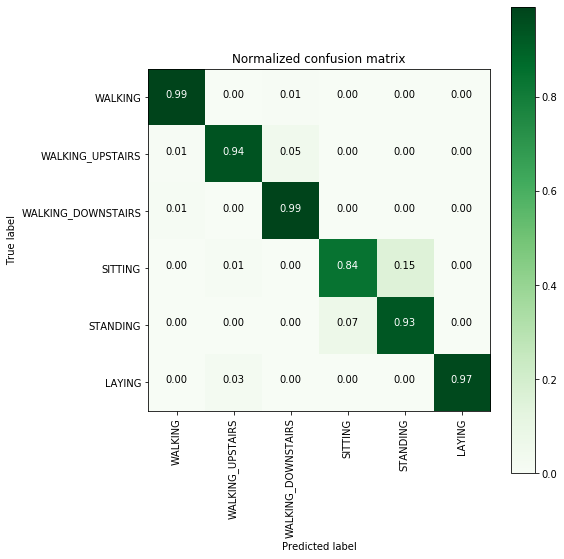

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

<h1>2. Conclusion </h1>

<h3>2.1 Models Output </h3>

In [104]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['LSTM Layer', 'Dropout', 'Loss', 'Accuracy']

table.add_row([32, 0.5, 0.41655886096877154, 0.8954869508743286])
table.add_row([64, 0.5, 0.35375094639873494, 0.9148286581039429])
table.add_row([64, 0.7, 'nan', 0.16830675303936005])
table.add_row([32, 0.7, 0.596762544016313, 0.8381404876708984])
table.add_row([64, 0.6, 0.4956902541945778, 0.9060060977935791])
table.add_row([32, 0.6, 0.5602035771178105, 0.8812351822853088])
table.add_row(['64+32', '2*0.7', 'nan', 0.16830675303936005])
table.add_row(['64+32', '2*0.6', 'nan', 0.16830675303936005])
table.add_row(['64+32', '2*0.5', 0.6456601167650766, 0.900237500667572])
table.add_row(['64+32', 0.7, 'nan', 0.16830675303936005])
table.add_row(['64+32', 0.6, 0.5375813010956876, 0.9053274393081665])
table.add_row(['64+32', 0.5, 0.3804781971405892, 0.9141499996185303])
table.add_row(['64+16', 0.5, 0.5414807511955393, 0.9056667685508728])
table.add_row(['32+16', 0.5, 0.3589311393391746, 0.922633171081543])
table.add_row(['32+8', 0.5, 0.3761567989555303, 0.7539871335029602])
table.add_row(['32+8', 0.5, 0.3761567989555303, 0.7539871335029602])
table.add_row(['32+8', 0.5, 0.3761567989555303, 0.7539871335029602])
table.add_row(['32+16', 0.6, 0.36157595883878874, 0.9100780487060547])
table.add_row(['32+16', 0.4, 0.39125852214684165, 0.9066847562789917])
table.add_row(['128', 0.25, 0.31214076887265046, 0.9256871342658997])
table.add_row(['Divide and Conquer', 'N/A', '-', 0.9443501866304717])

print(table)

+--------------------+---------+---------------------+---------------------+
|     LSTM Layer     | Dropout |         Loss        |       Accuracy      |
+--------------------+---------+---------------------+---------------------+
|         32         |   0.5   | 0.41655886096877154 |  0.8954869508743286 |
|         64         |   0.5   | 0.35375094639873494 |  0.9148286581039429 |
|         64         |   0.7   |         nan         | 0.16830675303936005 |
|         32         |   0.7   |  0.596762544016313  |  0.8381404876708984 |
|         64         |   0.6   |  0.4956902541945778 |  0.9060060977935791 |
|         32         |   0.6   |  0.5602035771178105 |  0.8812351822853088 |
|       64+32        |  2*0.7  |         nan         | 0.16830675303936005 |
|       64+32        |  2*0.6  |         nan         | 0.16830675303936005 |
|       64+32        |  2*0.5  |  0.6456601167650766 |  0.900237500667572  |
|       64+32        |   0.7   |         nan         | 0.16830675303936005 |

<h3>2.2 Steps I followed</h3>

- Did EDA on dataset
- Run classical machine learning models on 561 handcrafted features
- Run different LSTMs on raw time series data
- Tried 2 LSTMs with larger dropout, increase layer of LSTM from 32 to 64
- Above table contains different permutation and combination of LSTM that i tried
- Implement Divide and Conquer technique for classifying Static and Dynamic Activities and Merge Models for Activities Prediction

<h3>2.3 Divide and Conquer</h3>

- First classify static and dynamic activities, if label > 3 then static else dynamic
- Classify static activities (Sitting, Standing and Laying)
- Classify dynamic activities (Walking, Walking Upstairs and Walking Downstairs)
- Classify whole data on above three models

<h3>2.4 Best Model</h3>

- Divide and Conquer gives me 94.43% accuracy